In [1]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()

8

In [2]:
import tempfile
import json
import re
from typing import Dict, Iterable, List

import torch
from torch import optim
from allennlp.data.dataset_readers.dataset_reader import AllennlpDataset
from allennlp.data import DatasetReader, Instance, Vocabulary, Token, DataLoader
from allennlp.data.fields import LabelField, TextField, SpanField
from allennlp.data.token_indexers import (
    TokenIndexer,
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data.tokenizers import (
    Tokenizer,
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder, Seq2SeqEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.seq2seq_encoders import PassThroughEncoder
from allennlp.data.samplers import BasicBatchSampler, BucketBatchSampler, SequentialSampler
from allennlp.nn import util
from allennlp.training.metrics import CategoricalAccuracy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [4]:
data_dir = './data/'

In [5]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
train_df.selected_text[0] in train_df.text[0] 

True

In [8]:
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [9]:
def clean_text(text):
#     text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [10]:
def extend(row):
    selected_text = row.selected_text
    text = row.text
    assert selected_text in text, "origin selected text not in origin text"
    selected_text = clean_text(selected_text.strip())
    text = clean_text(text.strip())
    assert selected_text in text,( "selected text not in text", selected_text, text, row.selected_text, row.text)
    start = text.index(selected_text[0])
    end = text.rindex(selected_text[-1])
    while start > 0 and not text[start].isspace():
        start -= 1
    while end < len(text) and not text[end].isspace():
        end += 1
    selected_text = text[start: end]
    return pd.Series(data=[text, selected_text, row.sentiment], 
                     index=['text', 'selected_text', 'sentiment'])

In [11]:
cleaned_train_df = train_df.apply(extend, axis=1)
cleaned_train_df.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,boss is bullying me...,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative


In [12]:
def span(row):
    res = row.selected_text in row.text
    return res

In [13]:
is_span = cleaned_train_df.apply(span, axis=1)

In [14]:
is_span.all()

True

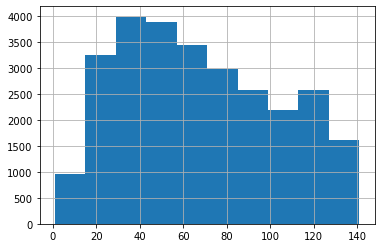

In [15]:
cleaned_train_df.text.str.len().hist()

In [16]:
cleaned_train_df.text.str.len().max()

141

In [17]:
len(cleaned_train_df)

27480

In [18]:
cleaned_train_df = cleaned_train_df.sample(frac=1, random_state=2020).reset_index(drop=True)
split_ratio = 0.2
split_idx = int(split_ratio * len(cleaned_train_df))
valid_df = cleaned_train_df.iloc[:split_idx]
train_df = cleaned_train_df.iloc[split_idx:]
len(train_df), len(valid_df)

(21984, 5496)

In [19]:
train_df.head()

,text,selected_text,sentiment
5496,"YAHOO! volleyball, hiking, eating a fish eye, ...","YAHOO! volleyball, hiking, eating a fish eye, ...",positive
5497,it starts @ 6. But we will be there until they...,it starts @ 6. But we will be there until they...,negative
5498,I didn`t check Twitter till just now. Thanks e...,Twitter till just now. Thanks everyone for al...,positive
5499,08.05.09 partying at the Pineforest http://tin...,08.05.09 partying at the Pineforest http://tin...,neutral
5500,aaaawww would u like an alcoholic beverage of ...,aaaawww would u like an alcoholic beverage of ...,neutral


In [20]:
train_df.to_csv('./data/clean_train.csv', index=False, encoding='utf8')
valid_df.to_csv('./data/clean_valid.csv', index=False, encoding='utf8')

In [21]:
transformer_model = './models/bert/'

In [22]:
tokenizer = PretrainedTransformerTokenizer(transformer_model)

In [23]:
token_indexer = PretrainedTransformerIndexer(model_name=transformer_model)

In [24]:
text = train_df.text[5600]
selected_text = train_df.selected_text[5600]

In [25]:
text, selected_text

('Defeated by a Polo', 'Defeated')

In [26]:
tokens = tokenizer.tokenize(text)
selected = tokenizer.tokenize(selected_text)

In [27]:
tokens, selected

([[CLS], defeated, by, a, polo, [SEP]], [[CLS], defeated, [SEP]])

In [28]:
tokens = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas', '.']
tokens = [Token(token) for token in tokens]
token_indexers = {'tokens': SingleIdTokenIndexer()}
text_field = TextField(tokens, token_indexers=token_indexers)

spans = [(2, 3), (5, 6)]    # ('an', 'elephant') and ('my', 'pajamas)
span_field = SpanField(2, 3, text_field)
print(span_field.get_padding_lengths())
span_field.as_tensor(span_field.get_padding_lengths())[0]

{}


tensor(2)

In [29]:
str(selected[1]), type(tokens[1])

('defeated', allennlp.data.tokenizers.token.Token)

In [30]:
selected[1], tokens[1], selected[1] == tokens[1]

(defeated, shot, False)

In [31]:
tokenizer.tokenize('positive')

[[CLS], positive, [SEP]]

In [32]:
@DatasetReader.register("sentiment-df")
class SentimentDfReader(DatasetReader):
    def __init__(self,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None,
                 max_tokens: int = None):
        super().__init__(lazy)
        self.tokenizer = tokenizer or PretrainedTransformerTokenizer(transformer_model)
        self.token_indexers = token_indexers or {'bert_tokens': PretrainedTransformerIndexer(transformer_model)}
        self.max_tokens = max_tokens

    def text_to_instance(self,
                         tokens: List[Token],
                         label: List[Token],
                         span: List[int] = None) -> Instance:
        if self.max_tokens:
            tokens = tokens[:self.max_tokens-2]
        tokens.extend(label)
        text_field = TextField(tokens, self.token_indexers)
        fields = {'text': text_field}
        if span:
            fields['span'] = SpanField(*span, text_field)
        return Instance(fields)

    def _read(self, file_path: str) -> Iterable[Instance]:
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            tokens = self.tokenizer.tokenize(row.text)
            str_tokens = [str(token) for token in tokens]
            selected_tokens = self.tokenizer.tokenize(row.selected_text)
            start = str_tokens.index(str(selected_tokens[1]))
            end = len(str_tokens) - str_tokens[::-1].index(str(selected_tokens[-2])) - 1
            span = [start, end]
            sentiment = self.tokenizer.tokenize(row.sentiment)[1:]
            yield self.text_to_instance(tokens, sentiment, span)

@Model.register("sentiment_extractor")
class TweetSentimentExtractor(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2SeqEncoder):
        super().__init__(vocab)
        self.embedder = embedder
        self.encoder = encoder
        self.start = torch.nn.Linear(embedder.get_output_dim(), 1)
        self.end = torch.nn.Linear(embedder.get_output_dim(), 1)

    def forward(self,
                text: Dict[str, torch.Tensor],
                span: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(text)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(text)
        # Shape: (batch_size, num_tokens, encoding_dim)
        encoded_text = self.encoder(embedded_text, mask)
        softmax_mask = torch.ones_like(mask, dtype=torch.float)
        softmax_mask[:, 0] = 1e-12
        softmax_mask[:, -3:] = 1e-12
        # Shape: (batch_size, text_length)
        start_logits = softmax_mask * self.start(encoded_text).squeeze()
        # Shape: (batch_size, text_length)
        end_logits = softmax_mask * self.end(encoded_text).squeeze()
        # Shape: (batch_size, text_length)
        start_probs = softmax_mask * torch.nn.functional.softmax(start_logits)
        end_probs = softmax_mask * torch.nn.functional.softmax(end_logits)
        # Shape: (1,)
        output = {'start_probs': start_probs, 'end_probs': end_probs}
        if span is not None:
            output['start_loss'] = torch.nn.functional.cross_entropy(start_logits, span[:, 0])
            output['end_loss'] = torch.nn.functional.cross_entropy(end_logits, span[:, 1])
            output['loss'] = output['start_loss'] + output['end_loss']
        return output

In [33]:
bert_model = './models/bert/'

In [34]:
reader = SentimentDfReader(lazy=False, 
                          tokenizer=PretrainedTransformerTokenizer(bert_model),
                          token_indexers={'bert_tokens': PretrainedTransformerIndexer(bert_model)},
                          max_tokens=145)

In [35]:
train_instances = reader.read(os.path.join(data_dir, 'clean_train.csv'))
valid_instances = reader.read(os.path.join(data_dir, 'clean_valid.csv'))

In [36]:
vocab = Vocabulary.from_instances(train_instances + valid_instances)

In [37]:
train_instances.index_with(vocab)
valid_instances.index_with(vocab)

In [38]:
embedding = PretrainedTransformerEmbedder(bert_model)
embedder = BasicTextFieldEmbedder(token_embedders={'bert': embedding})

In [39]:
s2sencoder = PassThroughEncoder(embedding.get_output_dim())

In [41]:
embedding.get_output_dim()

768

In [40]:
model = TweetSentimentExtractor(vocab, embedder, s2sencoder)

In [67]:
train_sampler = BucketBatchSampler(train_instances, batch_size=32, sorting_keys=['text'])
train_loader = DataLoader(train_instances, batch_sampler=train_sampler)

sampler = SequentialSampler(valid_instances)
valid_sampler = BasicBatchSampler(sampler, batch_size=32, drop_last=False)
valid_loader = DataLoader(valid_instances, batch_sampler=valid_sampler)

In [68]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = GradientDescentTrainer(model=model,
                                 optimizer=optimizer,
                                 data_loader=train_loader,
                                 patience=5,
                                 validation_metric="-loss",
                                 validation_data_loader=valid_loader,
                                 num_epochs=20,
                                 cuda_device=4,
                                 serialization_dir='./run/')

trainer.train()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select

In [52]:
config = {
    "dataset_reader" : {
        "type": "sentiment-df",
        "tokenizer": {
            "type": "pretrained_transformer",
            "model_name": bert_model,
        },
        "token_indexers": {
            "bert": {
                "type": "pretrained_transformer",
                "model_name": bert_model,
            }
        },
        "max_tokens": 145
    },
    "train_data_path": "./data/clean_train.csv",
    "validation_data_path": "./data/clean_valid.csv",
    "model": {
        "type": "sentiment_extractor",
        "embedder": {
            "token_embedders": {
                "bert": {
                    "type": "pretrained_transformer",
                    "model_name": bert_model
                }
            }
        },
        "encoder": {
            "type": "pass_through",
            "input_dim": 768
        }
    },
    "data_loader": {
        "batch_size": 256,
        "shuffle": True
    },
    "validation_data_loader": {
        "batch_size": 512,
        "shuffle": False
    },
    "trainer": {
        "optimizer": {
            "type": "huggingface_adamw",
            "lr": 1.0e-5
        },
        "num_epochs": 20,
        "patience": 5,
        "serialization_dir": './run/'
    },
    "distributed": {
        "cuda_devices": [4,5,6,7]
    }
}

In [53]:
serialization_dir = './run/'
config_filename = serialization_dir + "/training_config.json"
with open(config_filename, 'w') as config_file:
    json.dump(config, config_file)
from allennlp.commands.train import train_model_from_file
# Instead of this python code, you would typically just call
# allennlp train [config_file] -s [serialization_dir]
train_model_from_file(config_filename,
                      serialization_dir,
                      file_friendly_logging=True,
                      force=True)

Exception: 

-- Process 3 terminated with the following error:
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 20, in _wrap
    fn(i, *args)
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/commands/train.py", line 417, in _train_worker
    train_loop = TrainModel.from_params(
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 576, in from_params
    return retyped_subclass.from_params(
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 609, in from_params
    kwargs = create_kwargs(constructor_to_inspect, cls, params, **extras)
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 180, in create_kwargs
    constructed_arg = pop_and_construct_arg(
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 287, in pop_and_construct_arg
    return construct_arg(class_name, name, popped_params, annotation, default, **extras)
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 321, in construct_arg
    return annotation.from_params(params=popped_params, **subextras)
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/from_params.py", line 557, in from_params
    choice = params.pop_choice(
  File "/root/anaconda3/lib/python3.8/site-packages/allennlp/common/params.py", line 351, in pop_choice
    raise ConfigurationError(message)
allennlp.common.checks.ConfigurationError: sentiment-df not in acceptable choices for dataset_reader.type: ['conll2003', 'interleaving', 'sequence_tagging', 'sharded', 'babi', 'text_classification_json']. You should either use the --include-package flag to make sure the correct module is loaded, or use a fully qualified class name in your config file like {"model": "my_module.models.MyModel"} to have it imported automatically.
